# Exercise sheet

Some general remarks about the exercises:
* For your convenience functions from the lecture are included below. Feel free to reuse them without copying to the exercise solution box.
* For each part of the exercise a solution box has been added, but you may insert additional boxes. Do not hesitate to add Markdown boxes for textual or LaTeX answers (via `Cell > Cell Type > Markdown`). But make sure to replace any part that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove the `raise NotImplementedError()`.
* Please make your code readable by humans (and not just by the Python interpreter): choose informative function and variable names and use consistent formatting. Feel free to check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).
* Make sure that the full notebook runs without errors before submitting your work. This you can do by selecting `Kernel > Restart & Run All` in the jupyter menu.
* For some exercises test cases have been provided in a separate cell in the form of `assert` statements. When run, a successful test will give no output, whereas a failed test will display an error message.
* Each sheet has 100 points worth of exercises. Note that only the grades of sheets number 2, 4, 6, 8 count towards the course examination. Submitting sheets 1, 3, 5, 7 & 9 is voluntary and their grades are just for feedback.

Please fill in your name here:

In [1]:
NAME = "Kees van Kempen"
NAMES_OF_COLLABORATORS = ""

---

__Exercise sheet 2__

Code from the lecture:

In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import quad

rng = np.random.default_rng()
%matplotlib inline

def inversion_sample(f_inverse):
    '''Obtain an inversion sample based on the inverse-CDF f_inverse.'''
    return f_inverse(rng.random())

def compare_plot(samples,pdf,xmin,xmax,bins):
    '''Draw a plot comparing the histogram of the samples to the expectation coming from the pdf.'''
    xval = np.linspace(xmin,xmax,bins+1)
    binsize = (xmax-xmin)/bins
    # Calculate the expected numbers by numerical integration of the pdf over the bins
    expected = np.array([quad(pdf,xval[i],xval[i+1])[0] for i in range(bins)])/binsize
    measured = np.histogram(samples,bins,(xmin,xmax))[0]/(len(samples)*binsize)
    plt.plot(xval,np.append(expected,expected[-1]),"-k",drawstyle="steps-post")
    plt.bar((xval[:-1]+xval[1:])/2,measured,width=binsize)
    plt.xlim(xmin,xmax)
    plt.legend(["expected","histogram"])
    plt.show()
    
def gaussian(x):
    return np.exp(-x*x/2)/np.sqrt(2*np.pi)

## Sampling random variables via the inversion method 
__(35 Points)__

Recall from the lecture that for any real random variable $X$ we can construct an explicit random variable via the inversion method that is identically distributed. This random variable is given by $F_X^{-1}(U)$ where $F_X$ is the CDF of $X$ and $U$ is a uniform random variable on $(0,1)$ and 

$$
F_X^{-1}(p) := \inf\{ x\in\mathbb{R} : F_X(x) \geq p\}.
$$

This gives a very general way of sampling $X$ in a computer program, as you will find out in this exercise.

__(a)__ Let $X$ be an **exponential random variable** with **rate** $\lambda$, i.e. a continuous random variable with probability density function $f_X(x) = \lambda e^{-\lambda x}$ for $x > 0$. Write a function `f_inverse_exponential` that computes $F_X^{-1}(p)$. Illustrate the corresponding sampler with the help of the function `compare_plot` above. __(10 pts)__

Reasoning from the PDF, we can find the CDF and invert that as follows.

$$
f_X(x) = \lambda{}e^{-\lambda{}x}
$$
$$
\implies F_X(x)
       = \int_{-\infty}^x f_X(t)dt
       = \int_0^x \lambda{}e^{-\lambda{}t}dt
       = \left[ -e^{\lambda{}t} \right]_{t = 0}^x
       = 1 - e^{\lambda{}x}
       = \mathbb{P}(X \leq x) = p
$$
for $x \in [0, \infty)$, otherwise zero.

Now we seek $x$ as a function of $p$.

$$
1 - e^{\lambda{}x} = p
\iff -\lambda{}x = \ln{(1-p)}
\iff x = \frac{\ln{(1-p)}}{-\lambda} = F^{-1}_X(p)
$$
which works, as $1 - p \geq 0$ as $p \in [0, 1]$, allowing $\ln{0} = -\infty$.

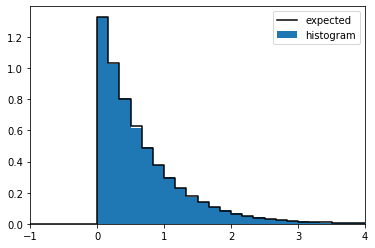

In [3]:
def f_inv_exponential(lam,p):
    return -np.log(1 - p)/lam

f_X = lambda x, lam: lam*np.exp(-lam*x) if x >= 0 else 0

# Input parameters as list for flexibility in testing.
for lam in [1.5]:
    pdf = lambda x: f_X(x, lam)
    samples = [inversion_sample(lambda p: f_inv_exponential(lam, p)) for _ in range(100000)]
    compare_plot(samples, pdf, -1, 4, 30)

In [4]:
from nose.tools import assert_almost_equal
assert_almost_equal(f_inv_exponential(1.0,0.6),0.916,delta=0.001)
assert_almost_equal(f_inv_exponential(0.3,0.2),0.743,delta=0.001)

__(b)__ Let now $X$ have the **Pareto distribution** of **shape** $\alpha > 0$ on $(b,\infty)$, which has  probability density function $f_X(x) = \alpha b^{\alpha} x^{-\alpha-1}$ for $x > b$. Write a function `f_inv_pareto` that computes $F_X^{-1}(p)$. Compare a histogram with a plot of $f_X(x)$ to verify your function numerically. __(10 pts)__

$$
f_X(x) = \alpha b^{\alpha} x^{-\alpha-1}
\\
\implies F_X(x) = \int_{-\infty}^x f_X(t)dt
                = \int_{b}^x \alpha{}b^\alpha{}t^{-\alpha-1}dt
                = \alpha{}b^\alpha{} \int_{b}^x t^{-\alpha-1}dt
                = \alpha{}b^\alpha{} \left[ \frac{-t^{-\alpha}}{\alpha} \right]_{t = b}^x
                = b^\alpha (b^{-\alpha} - x^{-\alpha}) = 1 - b^\alpha x^{-\alpha} = p,
$$
for $x > b$, otherwise $F_X(x) = 0$.

To find $F_X^{-1}(p)$, we write $p$ as function of $x$.

$$
p = 1 - b^\alpha x^{-\alpha}
\iff b^\alpha x^{-\alpha} = 1 - p
\iff x^{-\alpha} - b^{-\alpha}(1-p)
\iff x = \frac{b}{(1-p)^{1/\alpha}}
$$

Thus, $F_X^{-1}(p) = \frac{b}{(1-p)^{1/\alpha}}$ for $p \in [0, 1]$.

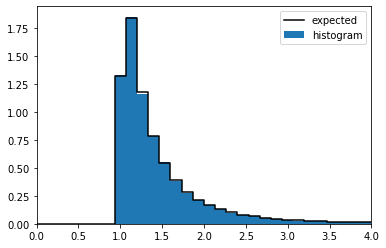

In [5]:
### Solution
def f_inv_pareto(alpha,b,p):
    return b/(1-p)**(1/alpha)

# plotting
f_X = lambda alpha, b, x: alpha*b**alpha*x**(-alpha-1) if x >= b else 0

# Input parameters as list for flexibility in testing.
for params in [(3., 1.)]:
    alpha, b = params
    pdf = lambda x: f_X(alpha, b, x)
    samples = [inversion_sample(lambda p: f_inv_pareto(alpha, b, p)) for _ in range(100000)]
    compare_plot(samples, pdf, b-1, 4, 30)

In [6]:
from nose.tools import assert_almost_equal
assert_almost_equal(f_inv_pareto(1.0,1.5,0.6),3.75,delta=0.0001)
assert_almost_equal(f_inv_pareto(2.0,2.25,0.3),2.689,delta=0.001)

__(c)__ Let $X$ be a discrete random variable taking values in $\{1,2,\ldots,n\}$. Write a Python function `f_inv_discrete` that takes the probability mass function $p_X$ as a list `prob_list` given by $[p_X(1),\ldots,p_X(n)]$ and returns a random sample with the distribution of $X$ using the inversion method. Verify the working of your function numerically on an example. __(15 pts)__

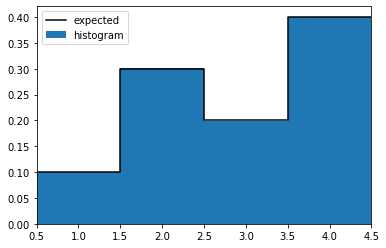

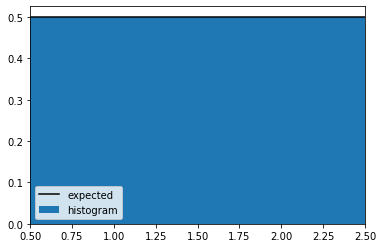

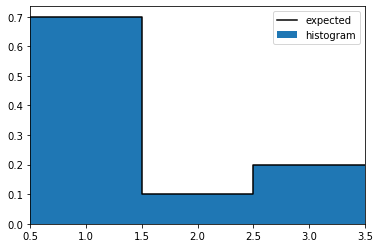

In [7]:
def f_inv_discrete(prob_list,p):
    assert np.isclose(np.sum(prob_list), 1), "The probabilities should sum to one."
    
    p_cum = 0
    i = 0
    while p_cum < p:
        p_cum += prob_list[i]
        i += 1
    return i

# plotting
f_X = lambda prob_list, x: prob_list[np.rint(x).astype(int) - 1] if np.rint(x) in range(1, len(prob_list) + 1) else 0

# Input parameters as list for flexibility in testing.
for prob_list in [[.1, .3, .2, .4], [0.5, 0.5], [0.7, 0.1, 0.2]]:
    alpha, b = params
    pdf = lambda x: f_X(prob_list, x)
    samples = [inversion_sample(lambda p: f_inv_discrete(prob_list, p)) for _ in range(100000)]
    compare_plot(samples, pdf, .5, len(prob_list) + .5, len(prob_list))

In [8]:
assert f_inv_discrete([0.5,0.5],0.4)==1
assert f_inv_discrete([0.5,0.5],0.8)==2
assert f_inv_discrete([0,0,1],0.1)==3

## Central limit theorem? 
__(35 Points)__

In this exercise we will have a closer look at central limits of the Pareto distribution, for which you implemented a random sampler in the previous exercise. By performing the appropriate integrals it is straightforward to show that 

$$ 
\mathbb{E}[X] = \begin{cases} \infty & \text{for }\alpha \leq 1 \\ \frac{\alpha b}{\alpha - 1} & \text{for }\alpha > 1 \end{cases}, \qquad \operatorname{Var}(X) = \begin{cases} \infty & \text{for }\alpha \leq 2 \\ \frac{\alpha b^2}{(\alpha - 1)^2(\alpha-2)} & \text{for }\alpha > 2 \end{cases}.
$$

This shows in particular that the distribution is **heavy tailed**, in the sense that some moments $\mathbb{E}[X^k]$ diverge.

__(a)__ Write a function `sample_Zn` that produces a random sample for $Z_n= \frac{\sqrt{n}}{\sigma_X}(\bar{X}_n - \mathbb{E}[X])$ given $\alpha>2$, $b>0$ and $n\geq 1$. Visually verify the central limit theorem for $\alpha = 4$, $b=1$ and $n=1000$ by comparing a histogram of $Z_n$ to the standard normal distribution (you may use `compare_plot`). __(10 pts)__

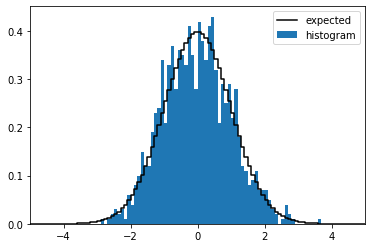

In [9]:
def sample_Zn(alpha,b,n):
    assert alpha > 2
    assert b > 0
    assert n >= 1 and type(n) == int
    
    E_X = alpha*b/(alpha - 1)
    Var_X = alpha*b**2/( (alpha - 1)**2*(alpha - 2) )
    
    inv_pareto_samples = [inversion_sample(lambda p: f_inv_pareto(alpha, b, p)) for _ in range(n)]
    return np.sqrt(n/Var_X)*(np.mean(inv_pareto_samples) - E_X)

# Plotting
alpha = 4
b = 1
n = 1000
pdf = gaussian
samples = [inversion_sample(lambda p: sample_Zn(alpha, b, n)) for _ in range(1000)]
compare_plot(samples, pdf, -5, 5, 100)

In [10]:
assert_almost_equal(np.mean([sample_Zn(3.5,2.1,100) for _ in range(100)]),0,delta=0.3)
assert_almost_equal(np.std([sample_Zn(3.5,2.1,100) for _ in range(100)]),1,delta=0.3)

__(b)__ Now take $\alpha = 3/2$ and $b=1$. 
With some work (which you do not have to do) one can show that the characteristic function of $X$ admits the following expansion around $t=0$,

$$
\varphi_X(t) = 1 + 3 i t - (|t|+i t)\,\sqrt{2\pi|t|} + O(t^{2}).
$$

Based on this, prove the **generalized CLT** for this particular distribution $X$ which states that $Z_n = c\, n^{1/3} (\bar{X}_n - \mathbb{E}[X])$ in the limit $n\rightarrow\infty$ converges in distribution, with a to-be-determined choice of overall constant $c$, to a limiting random variable $\mathcal{S}$ with characteristic function 

$$
\varphi_{\mathcal{S}}(t) = \exp\big(-(|t|+it)\sqrt{|t|}\big).
$$

__(15 pts)__

\begin{align}
\phi_{Z_n}(t) &= \mathbb{E}\left[ e^{itZ_n} \right]
           \\ &= \mathbb{E}\left[ e^{itcn^{1/3}(\bar{X_n} - \mathbb{E}[X])} \right]
           \\ &= \mathbb{E}\left[ e^{itcn^{1/3}(\frac{1}{n}\sum_{i=1}^n X_i - \mathbb{E}[X])} \right]
           \\ &= \mathbb{E}\left[ \left( \prod_{i=1}^n e^{itcn^{-2/3}X_i} \right) e^{itcn^{1/3}\mathbb{E}[X])} \right]
           \\ &= \left( \prod_{i=1}^n \mathbb{E}\left[  e^{itcn^{-2/3}X_i} \right] \right)\mathbb{E}\left[ e^{itcn^{1/3}\mathbb{E}[X])} \right]
           \\ &= \left( \prod_{i=1}^n \phi_X(cn^{-2/3}t) \right)\mathbb{E}\left[ e^{itcn^{1/3}\mathbb{E}[X])} \right]
           \\ &= \left( \phi_X(cn^{-2/3}t) \right)^n \mathbb{E}\left[ e^{itcn^{1/3}\mathbb{E}[X])} \right]
\end{align}
where we used the identity for products of indepedent expectation values <https://hef.ru.nl/~tbudd/mct/lectures/probability_random_variables.html#equation-product-expectation>, and the definition of $\phi_X(t) := \mathbb{E}\left[ e^{itX} \right]$.

Next, we will use the Taylor expansion around $t = 0$ as is given above, and, for the latter exponential, $\mathbb{E}(X) = 3$ for $\alpha = 3/2, b = 1$ as given.

\begin{align}
\phi_{Z_n}(t) &= \left( \phi_X(cn^{-2/3}t) \right)^n \mathbb{E}\left[ e^{itcn^{1/3}\mathbb{E}[X])} \right]
           \\ &= \left( 1 + 3 i cn^{-2/3}t - (|cn^{-2/3}t|+i cn^{-2/3}t)\,\sqrt{2\pi|cn^{-2/3}t|} + \mathcal{O}(t^2) \right)^n e^{3itcn^{1/3}}
           \\ &= \left( 1 + \frac{1}{n} \left[ 3 i cn^{1/3}t - (|ct|+i ct)\,\sqrt{2\pi|ct|} \right] + \mathcal{O}(t^2) \right)^n e^{3itcn^{1/3}}
\end{align}

Taking the limit $n \to \infty$, the first set of parentheses can be rewritten in terms of an exponential using the identity $\lim_{n\to\infty} (1 + \frac{a}{n})^n = e^{a}$, we find a way to our desired expression.

\begin{align}
\lim_{n\to\infty} \phi_{Z_n}(t) &= \lim_{n\to\infty} \left( 1 + \frac{1}{n} \left[ 3 i cn^{1/3}t - (|ct|+i ct)\,\sqrt{2\pi|ct|} \right] + \mathcal{O}(t^2) \right)^n e^{-3itcn^{1/3}}
           \\ &= \lim_{n\to\infty} \exp{({3 i cn^{1/3}t - (|ct|+i ct)\,\sqrt{2\pi|ct|}})} \exp{(e^{-3itcn^{1/3}})}
           \\ &= \exp{({-(|ct|+i ct)\,\sqrt{2\pi|ct|}})}
\end{align}

This matches $\phi_S(t) = \exp\big(-(|t|+it)\sqrt{|t|}\big)$ for $\sqrt{2\pi} c^{3/2} = 1 \implies c = (2\pi)^{\frac{-1}{3}}$.

__(c)__ The random variable $\mathcal{S}$ has a [stable Lévy distribution](https://en.wikipedia.org/wiki/Stable_distribution) with index $\alpha = 3/2$ and skewness $\beta = 1$. Its probability density function $f_{\mathcal{S}}(x)$ does not admit a simple expression, but can be accessed numerically using SciPy's `scipy.stats.levy_stable.pdf(x,1.5,1.0)`. Verify numerically that the generalized CLT of part (b) holds by comparing an appropriate histogram to this PDF. __(10 pts)__

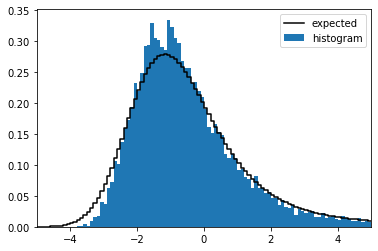

In [11]:
from scipy.stats import levy_stable

def sample_Zn(alpha, beta, c, n):
    assert n >= 1 and type(n) == int
    
    E_X = alpha*b/(alpha - 1)
    
    samples = [inversion_sample(lambda p: f_inv_pareto(alpha, beta, p)) for _ in range(n)]
    return c*n**(1/3)*(np.mean(samples) - E_X)

alpha = 3/2
beta  = 1
c     = (2*np.pi)**(-1/3)
n     = 1000
pdf = lambda x: levy_stable.pdf(x, alpha, beta)
samples = [sample_Zn(alpha, b, c, n) for _ in range(10000)]
compare_plot(samples, pdf, -5, 5, 100)

## Joint probability density functions and sampling the normal distribution 
__(30 Points)__

Let $\Phi$ be a uniform random variable on $(0,2\pi)$ and $R$ an independent continuous random variable with probability density function $f_R(r) = r\,e^{-r^2/2}$ for $r>0$. Set $X = R \cos \Phi$ and $Y = R \sin \Phi$. This is called the **Box-Muller transform**.

__(a)__ Since $\Phi$ and $R$ are independent, the joint probability density of $\Phi$ and $R$ is $f_{\Phi,R}(\phi,r) = f_\Phi(\phi)f_R(r) = \frac{1}{2\pi}\, r\,e^{-r^2/2}$. Show by change of variables that $X$ and $Y$ are also independent and both distributed as a standard normal distribution $\mathcal{N}$. __(15 pts)__

The coordinate transformation $T$ is defined as $T(\Phi, R) = (R\cos{\Phi}, R\sin{\Phi}) = (X, Y)$. As $T$ is invertible differentiable, we can write the equality between the joint probability density in both coordinate pairs as follows, using the Jacobian.
$$
f_{X,Y}(x,y) \Big|\frac{\mathrm{d}x}{\mathrm{d}\phi}\frac{\mathrm{d}y}{\mathrm{d}r}-\frac{\mathrm{d}y}{\mathrm{d}\phi}\frac{\mathrm{d}x}{\mathrm{d}r}\Big|
= f_{X,Y}(T(\phi,r)) \Big|\frac{\mathrm{d}x}{\mathrm{d}\phi}\frac{\mathrm{d}y}{\mathrm{d}r}-\frac{\mathrm{d}y}{\mathrm{d}\phi}\frac{\mathrm{d}x}{\mathrm{d}r}\Big|
= f_{X,Y}(T(\phi,r)) \Big|-r\sin{\phi}\sin{\phi}-r\cos{\phi}\cos{\phi}\Big|
= f_{X,Y}(T(\phi,r)) r
= f_{\Phi,R}(\phi,r)
= \frac{1}{2\pi}\, r\,e^{-r^2/2}
\\ \implies f_{X,Y}(x,y) =  \frac{1}{2\pi}\,e^{-r^2/2} = \frac{1}{\sqrt{2\pi}}e^{-x^2/2}\frac{1}{\sqrt{2\pi}}e^{-y^2/2} = f_{X}(x)f_Y(y)
$$
using that $r^2 = x^2 + y^2$ in the second to last step. We conclude that $X$ and $Y$ are independent, and the factorization shows that they are both distributed as a standard normal distribution $\mathcal{N}(0,1)$.

__(b)__ Write a function to sample a pair of independent normal random variables using the Box-Muller transform. Hint: to sample $R$ you can use the inversion method of the first exercise. Produce a histogram to check the distribution of your normal variables. __(15 pts)__

For the sampling of $R$, we take its PDF, calculate its CDF, invert it, and use the function `inversion_sample` to pull values for $R$.

$$
f_R(r) = re^{-r^2/2}
\\ \implies F_R(r) = \int_{0}^r te^{-t^2/2}dt = 1-e^{-r^2/2}
$$
integrating over values $r > 0$ as it cannot be negative, and using a substitution with $z := t^2$.

Now the inversion.

$$
p := F_R(r) = 1-e^{-r^2/2} \implies r = \sqrt{-2\ln{(1-p)}}
$$
for $p \in [0, 1]$. Do note that we can also calculate $r = \sqrt{-2\ln{(p)}}$ as $p$ and $1 - p$ are identically distributed, also keeping the argument to $\ln$ positive, saving just one calculation, although I do not use this in the following.

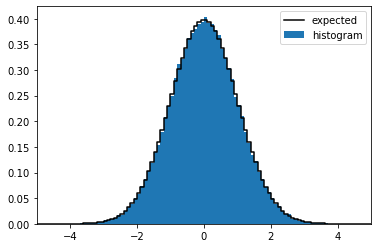

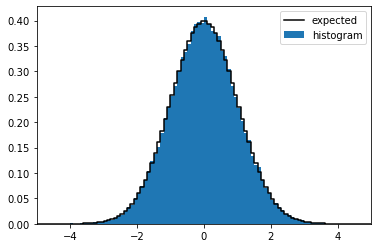

In [12]:
def random_normal_pair():
    '''Return two independent normal random variables.'''
    phi = rng.random()*2*np.pi
    r = inversion_sample(lambda p: np.sqrt(-2*np.log(1-p)))
    x, y = r*np.cos(phi), r*np.sin(phi)
    return x, y

# Plotting
pdf = gaussian
samples = np.array([random_normal_pair() for _ in range(100000)])
for index in [0, 1]:
    compare_plot(samples[:,index], pdf, -5, 5, 100) 